# Testing test dataset for any trends, 
VADERS, Roberta from torch, and Pipeline with pretrained transformers and models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('dark_background')

import nltk

In [2]:
#reading data, last four columns

df = pd.read_csv('data/test_new.csv', usecols = ['brand', 'review_title', 'review_text', 'review_rating'])
###df = df.sample(n=1000)
df.shape

(14063, 4)

Text(0.5, 0, 'Review by numeric')

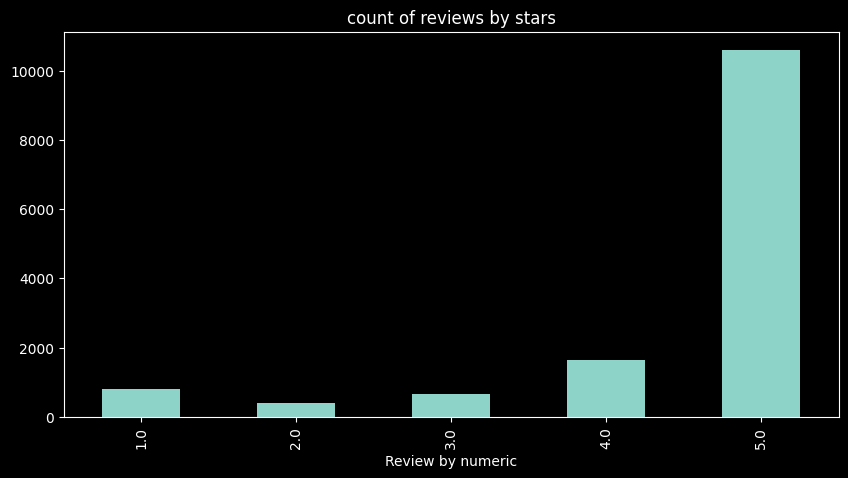

In [3]:
#quick eda

ax = df['review_rating'].value_counts().sort_index(). \
    plot(kind='bar',
         title='count of reviews by stars',
         figsize=(10,5))
ax.set_xlabel('Review by numeric')

In [4]:
#preprocessing:
df['review_text'] = df['review_text'].str.replace(r'[^\w\s]', '', regex=True)
df['review_text'] = df['review_text'].str.lower()
df['review_text'] = df['review_text'].str.strip()
df['review_text'] = df['review_text'].str.replace(r'\s+', ' ', regex=True)
df['review_text'] = df['review_text'].str.replace(r'\d+', '', regex=True)
df = df.map(str)

# nltk simple simulation start // test out example with tokenziation and premade models

In [5]:
example = df['review_text'][6563]
print(example)

tokens = nltk.word_tokenize(example)
print(tokens[10:])

its hard to beat tide pods for convenience ive never had any problems with them like some people have reported i throw a pod into the bottom of the washer put clothes in and push start on the machine clothes and my laundry room smell great clothes are clean and im happy very convenient
['had', 'any', 'problems', 'with', 'them', 'like', 'some', 'people', 'have', 'reported', 'i', 'throw', 'a', 'pod', 'into', 'the', 'bottom', 'of', 'the', 'washer', 'put', 'clothes', 'in', 'and', 'push', 'start', 'on', 'the', 'machine', 'clothes', 'and', 'my', 'laundry', 'room', 'smell', 'great', 'clothes', 'are', 'clean', 'and', 'im', 'happy', 'very', 'convenient']


In [6]:
tagged = nltk.pos_tag(tokens)
print(tagged)

[('its', 'PRP$'), ('hard', 'NN'), ('to', 'TO'), ('beat', 'VB'), ('tide', 'JJ'), ('pods', 'NNS'), ('for', 'IN'), ('convenience', 'NN'), ('ive', 'JJ'), ('never', 'RB'), ('had', 'VBD'), ('any', 'DT'), ('problems', 'NNS'), ('with', 'IN'), ('them', 'PRP'), ('like', 'IN'), ('some', 'DT'), ('people', 'NNS'), ('have', 'VBP'), ('reported', 'VBN'), ('i', 'JJ'), ('throw', 'VBP'), ('a', 'DT'), ('pod', 'NN'), ('into', 'IN'), ('the', 'DT'), ('bottom', 'NN'), ('of', 'IN'), ('the', 'DT'), ('washer', 'NN'), ('put', 'VBD'), ('clothes', 'NNS'), ('in', 'IN'), ('and', 'CC'), ('push', 'JJ'), ('start', 'NN'), ('on', 'IN'), ('the', 'DT'), ('machine', 'NN'), ('clothes', 'NNS'), ('and', 'CC'), ('my', 'PRP$'), ('laundry', 'JJ'), ('room', 'NN'), ('smell', 'NN'), ('great', 'JJ'), ('clothes', 'NNS'), ('are', 'VBP'), ('clean', 'JJ'), ('and', 'CC'), ('im', 'JJ'), ('happy', 'JJ'), ('very', 'RB'), ('convenient', 'JJ')]


In [7]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint

<bound method Tree.pprint of Tree('S', [('its', 'PRP$'), ('hard', 'NN'), ('to', 'TO'), ('beat', 'VB'), ('tide', 'JJ'), ('pods', 'NNS'), ('for', 'IN'), ('convenience', 'NN'), ('ive', 'JJ'), ('never', 'RB'), ('had', 'VBD'), ('any', 'DT'), ('problems', 'NNS'), ('with', 'IN'), ('them', 'PRP'), ('like', 'IN'), ('some', 'DT'), ('people', 'NNS'), ('have', 'VBP'), ('reported', 'VBN'), ('i', 'JJ'), ('throw', 'VBP'), ('a', 'DT'), ('pod', 'NN'), ('into', 'IN'), ('the', 'DT'), ('bottom', 'NN'), ('of', 'IN'), ('the', 'DT'), ('washer', 'NN'), ('put', 'VBD'), ('clothes', 'NNS'), ('in', 'IN'), ('and', 'CC'), ('push', 'JJ'), ('start', 'NN'), ('on', 'IN'), ('the', 'DT'), ('machine', 'NN'), ('clothes', 'NNS'), ('and', 'CC'), ('my', 'PRP$'), ('laundry', 'JJ'), ('room', 'NN'), ('smell', 'NN'), ('great', 'JJ'), ('clothes', 'NNS'), ('are', 'VBP'), ('clean', 'JJ'), ('and', 'CC'), ('im', 'JJ'), ('happy', 'JJ'), ('very', 'RB'), ('convenient', 'JJ')])>

## Using our own dataset, splitting each score by bad and good subjectivity 

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
#progress bar

sia = SentimentIntensityAnalyzer()

print(example)
sia.polarity_scores(example)

its hard to beat tide pods for convenience ive never had any problems with them like some people have reported i throw a pod into the bottom of the washer put clothes in and push start on the machine clothes and my laundry room smell great clothes are clean and im happy very convenient


{'neg': 0.022, 'neu': 0.734, 'pos': 0.244, 'compound': 0.9307}

In [31]:
from nltk.sentiment import SentimentAnalyzer
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment.util import *
from nltk.corpus import subjectivity
sa = SentimentAnalyzer()
def label_from_rating(rating):
    if float(rating) >= 4.0:
        return 'pos'
    elif float(rating) <= 2.0:
        return 'neg'
    else:
        return 'neu'

df['label'] = df['review_rating'].apply(label_from_rating)
training_set = [(text.split(), label) for text, label in zip(df['review_text'], df['label'])]
trainer = NaiveBayesClassifier.train
feature_set = sa.apply_features(training_set)
classifier = sa.train(trainer, feature_set)

Training classifier


## Pre-trained VADER model 

In [9]:
res = {}
res_numeric = {}
for i, row in tqdm(df.iterrows(), total=len(df)): 
    text = row['review_text']
    category = row['brand'] 
    res[category] = sia.polarity_scores(text)
    res_numeric[i+1] = sia.polarity_scores(text)

  0%|          | 0/14063 [00:00<?, ?it/s]

In [32]:
vaders_res = pd.DataFrame(res).T
vaders = pd.DataFrame(res_numeric).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.iloc[:, :5]
vaders = pd.concat([df, vaders], axis=1)

In [33]:
#new dataset with sentimental columns added
vaders.head()

,brand,review_title,review_text,review_rating,label,id,neg,neu,pos,compound
0,Downy,Downy Softness,i used to stay away from scented laundry produ...,5.0,pos,1,0.000,0.840,0.160,0.9243
1,Tide,nan,great item,5.0,pos,2,0.000,0.196,0.804,0.6249
2,Cascade,Five Stars,arrived soon product is as expected,5.0,pos,3,0.000,1.000,0.000,0.0000
3,Swiffer,Five Stars,yup these work well,5.0,pos,4,0.000,0.588,0.412,0.2732
4,Swiffer,Too Costly Considering the Result.,if you have a relatively clean floor with a fe...,2.0,neg,5,0.055,0.758,0.188,0.7184


In [34]:
#converingg review ratings to int values
vaders['review_rating'] = pd.to_numeric(vaders['review_rating'], errors='coerce')
vaders = vaders.sort_values('review_rating')

## VADERS Plot 

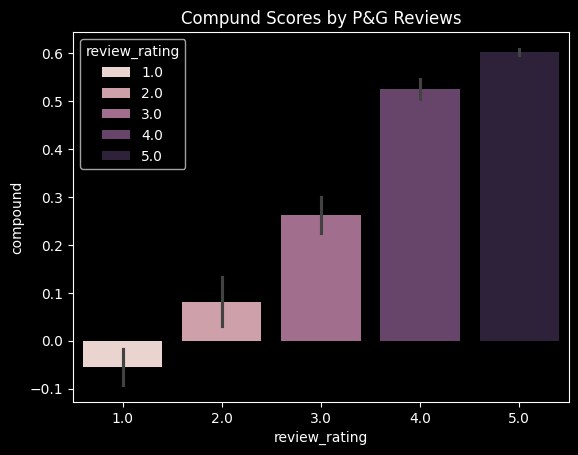

In [36]:
ax = sns.barplot(data=vaders, x='review_rating', y='compound', hue='review_rating')
ax.set_title('Compund Scores by P&G Reviews')
plt.show()

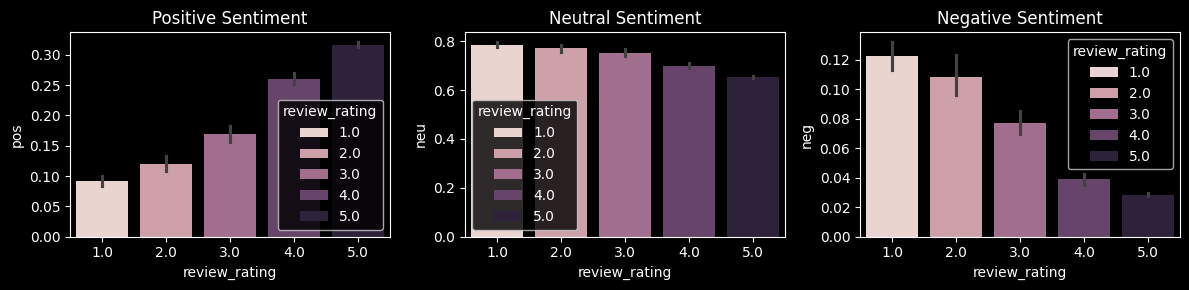

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

sns.barplot(data=vaders, x='review_rating', y='pos', ax=axs[0], hue='review_rating')
sns.barplot(data=vaders, x='review_rating', y='neu', ax=axs[1], hue='review_rating')
sns.barplot(data=vaders, x='review_rating', y='neg', ax=axs[2], hue='review_rating')
axs[0].set_title('Positive Sentiment')
axs[1].set_title('Neutral Sentiment')
axs[2].set_title('Negative Sentiment')
plt.tight_layout()
plt.show()

# Roberta Pre-trained model 

In [38]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [39]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [40]:
#VADER 
print(example)
sia.polarity_scores(example)

its hard to beat tide pods for convenience ive never had any problems with them like some people have reported i throw a pod into the bottom of the washer put clothes in and push start on the machine clothes and my laundry room smell great clothes are clean and im happy very convenient


{'neg': 0.022, 'neu': 0.734, 'pos': 0.244, 'compound': 0.9307}

In [41]:
#ROBERTA with transformer applying to example of our dataset
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores
# 3 different values in numpy array instead 
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
scores_dict

{'roberta_neg': np.float32(0.014538411),
 'roberta_neu': np.float32(0.059165753),
 'roberta_pos': np.float32(0.9262958)}

In [42]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores
    # 3 different values in numpy array instead 
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [45]:
res = {} 
for i, row in tqdm(df.iterrows(), total=len(df)): 
    try:
        text = row['review_text']
        vader_numeric = sia.polarity_scores(text)
        roberta_numeric = polarity_scores_roberta(text)
        vader_numeric_rename = {}
        num = i+1
        for key, value in vader_numeric.items():
            vader_numeric_rename[f"vader_{key}"] = value
        both = {**vader_numeric_rename, **roberta_numeric}
        res[num] = both
    except RuntimeError:
        print(f'broke for review {text}')

  0%|          | 0/14063 [00:00<?, ?it/s]

broke for review we have a very active two year old son and at the end of every day his clothes look like hes been through a tough mudder race or a food fight and no matter what brand of liquid detergent we used it was always never enough hence our regular laundry routine involves using and carefully measuring portions of liquid detergent oxiclean powder and a fabric softener do get a decent clean we were skeptical that a single pod or two for our large loads would replace of that and provide a similar clean let alone a better one and we were in for a nice surprise using them we normally do our laundry once a week which means we have a large load and have to use two of these pods and do them on a warm wash cycle see pics the pods have three chambers filled with different colored liquids main detergent stain remover fabric softener side note they are so jello squishy that both me and my wife had to resist the temptation to pop them really beats out the hassle of measuring and pouring de

In [46]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = pd.concat([df, results_df], axis=1)

In [47]:
results_df.head()

,brand,review_title,review_text,review_rating,label,id,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos
0,Downy,Downy Softness,i used to stay away from scented laundry produ...,5.0,pos,1.0,0.000,0.840,0.160,0.9243,0.013716,0.115414,0.870870
1,Tide,nan,great item,5.0,pos,2.0,0.000,0.196,0.804,0.6249,0.006715,0.066720,0.926564
2,Cascade,Five Stars,arrived soon product is as expected,5.0,pos,3.0,0.000,1.000,0.000,0.0000,0.006330,0.332023,0.661647
3,Swiffer,Five Stars,yup these work well,5.0,pos,4.0,0.000,0.588,0.412,0.2732,0.003548,0.064545,0.931907
4,Swiffer,Too Costly Considering the Result.,if you have a relatively clean floor with a fe...,2.0,neg,5.0,0.055,0.758,0.188,0.7184,0.410421,0.487123,0.102456


In [48]:
results_df.columns

Index(['brand', 'review_title', 'review_text', 'review_rating', 'label', 'id',
       'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound', 'roberta_neg',
       'roberta_neu', 'roberta_pos'],
      dtype='object')

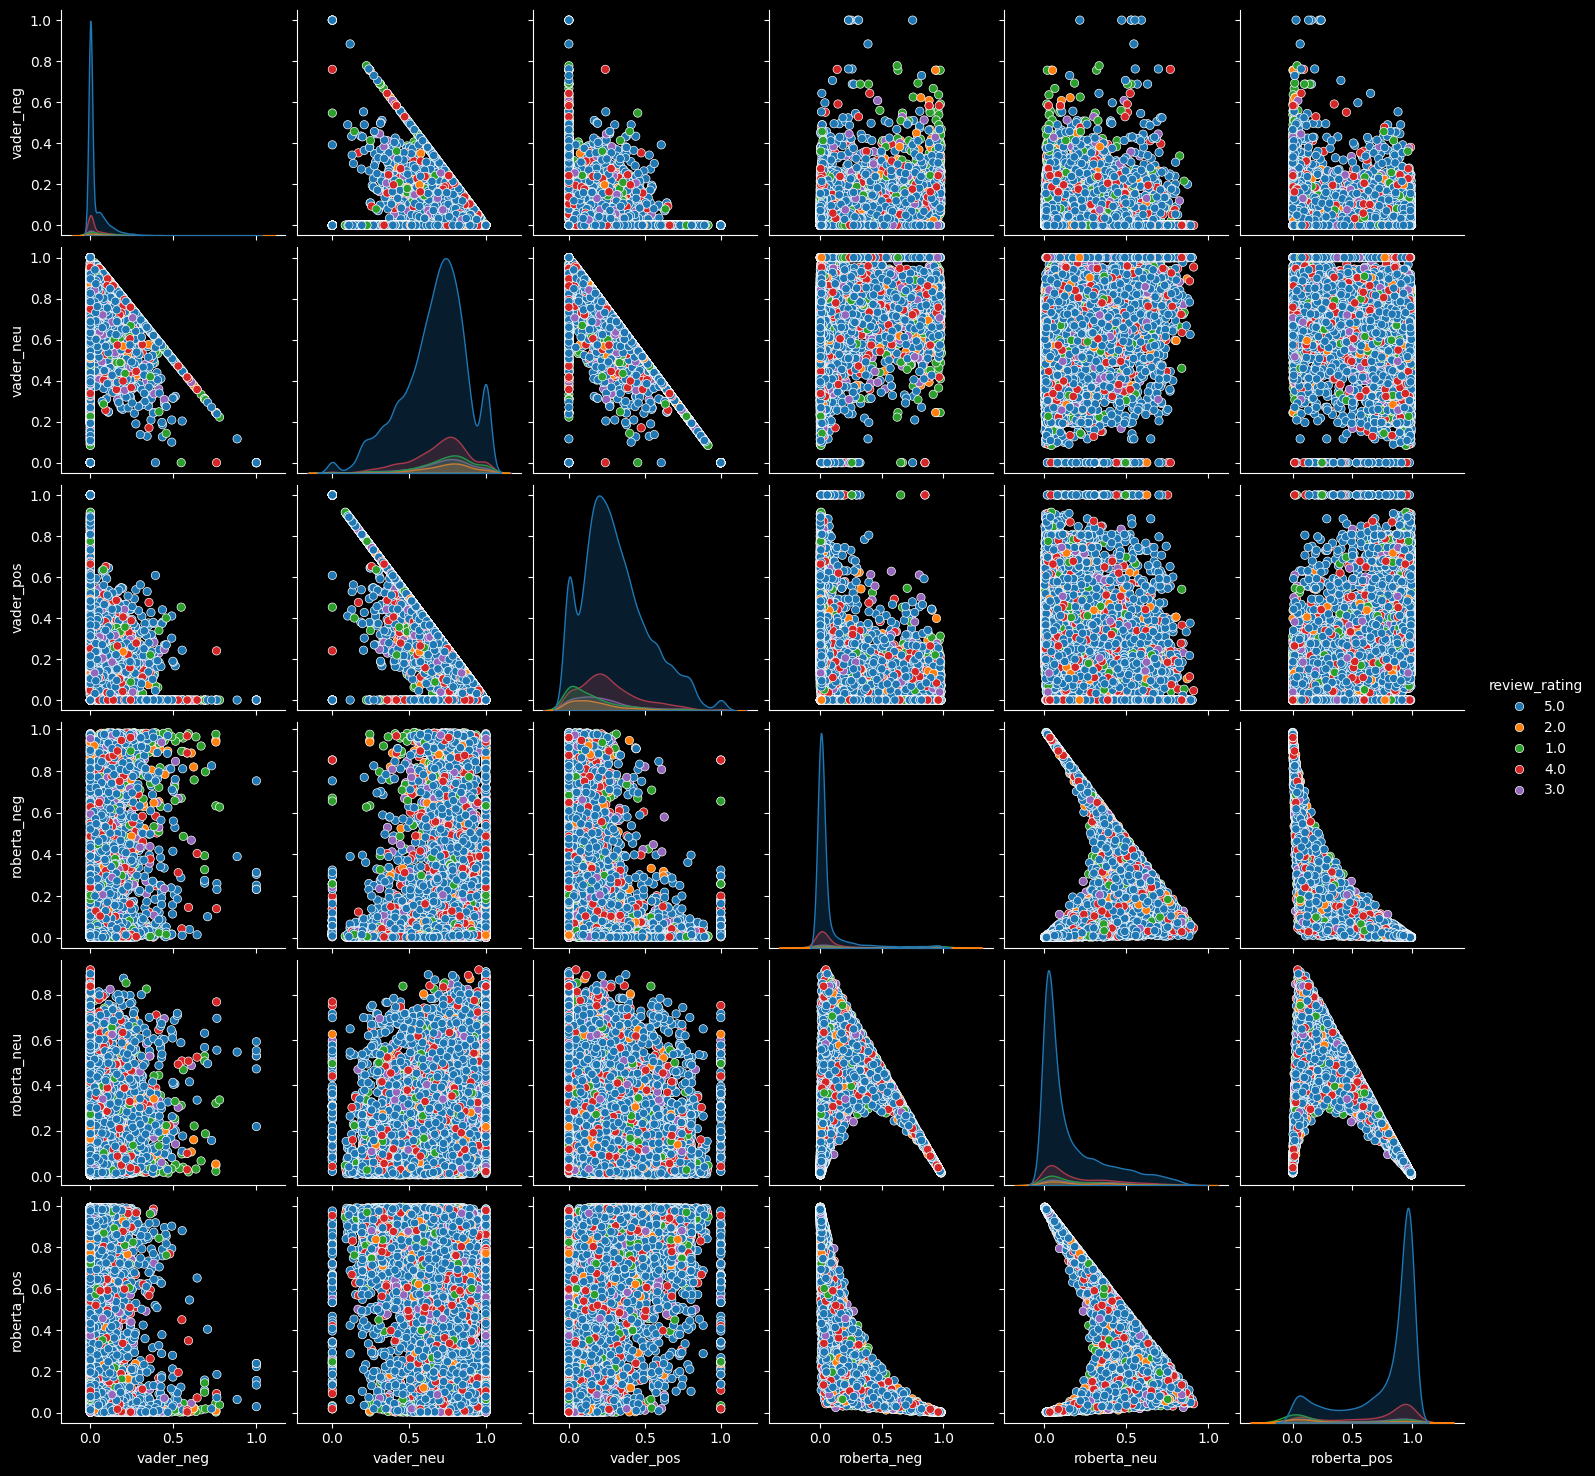

In [49]:
sns.pairplot(data=results_df, vars=['vader_neg', 'vader_neu', 'vader_pos', 'roberta_neg',
       'roberta_neu', 'roberta_pos'], hue='review_rating', palette='tab10')
plt.show()

# Review Examples (sentiment error)

In [50]:
results_df['review_rating'] = pd.to_numeric(results_df['review_rating'], errors='coerce')
results_df.query('review_rating == 1') \
    .sort_values('roberta_pos', ascending=False)['review_text'].values[1]

'product is amazing love the smell however it is advertised as pack of  here and i only received one please read the fine print'

In [51]:
results_df.query('review_rating == 1') \
    .sort_values('vader_pos', ascending=False)['review_text'].values[1]

'it was great while it worked on hardwood and tile but the rubber insert holders that held the cloth started to break and couldnt be repaired'

In [52]:
results_df.query('review_rating == 5') \
    .sort_values('roberta_neg', ascending=False)['review_text'].values[0]

'i recommend the lemon scent detergent because it makes my dishes smell great besides being very clean unlike other products i have been using cascade detergent for  years and have never had any problems with this brand of detergent it leaves my dishes sparkling clean this review was collected as part of a promotion'

In [53]:
results_df.query('review_rating == 5') \
    .sort_values('vader_neg', ascending=False)['review_text'].values[0]

'gain dish soap has a very beautiful scent and is a good quality dish detergent for the price and is not harsh on your skin'

# Sentiement pipeline

In [54]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use mps:0


In [55]:
sent_pipeline(example)

[{'label': 'POSITIVE', 'score': 0.9989884495735168}]

In [56]:
example

'its hard to beat tide pods for convenience ive never had any problems with them like some people have reported i throw a pod into the bottom of the washer put clothes in and push start on the machine clothes and my laundry room smell great clothes are clean and im happy very convenient'

In [57]:
sent_pipeline("if only I had something to magically make these tie-pods work. \
These work as good as magic. Good thing magic isn't real!")

[{'label': 'POSITIVE', 'score': 0.9970754384994507}]

In [58]:
sent_pipeline("I hate tie-pods for the life of me, I hate everything about them!")

[{'label': 'NEGATIVE', 'score': 0.9985942244529724}]

In [59]:
sent_pipeline("wow really huh")

[{'label': 'POSITIVE', 'score': 0.9990172386169434}]

## Analysis Dashboard

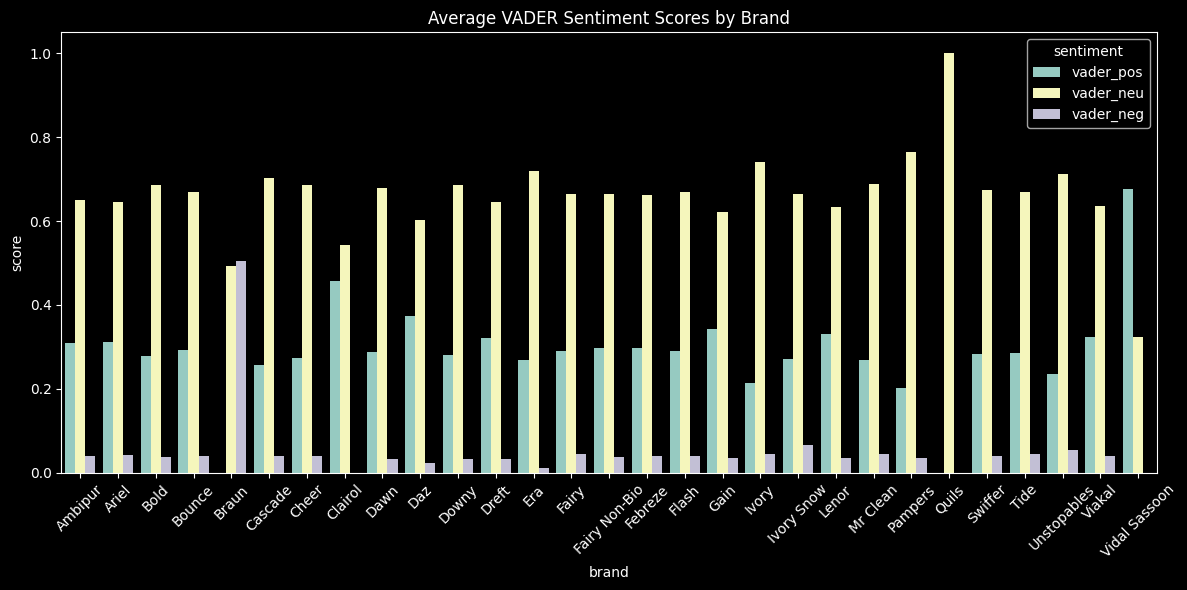

In [63]:
brand_sentiment = results_df.groupby('brand')[['vader_pos', 'vader_neu', 'vader_neg']].mean().reset_index()
brand_avg = brand_sentiment.melt(id_vars='brand', var_name='sentiment', value_name='score')
plt.figure(figsize=(12, 6))
sns.barplot(data=brand_avg, x='brand', y='score', hue='sentiment')
plt.title('Average VADER Sentiment Scores by Brand')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [75]:
concerning_reviews = results_df[results_df['vader_neg'] > 0.5][['brand', 'review_rating', 'review_title', 'review_text', 'vader_neg', 'vader_neu', 'vader_pos']]
len(concerning_reviews)
concerning_reviews[0:10]

,brand,review_rating,review_title,review_text,vader_neg,vader_neu,vader_pos
37,Cascade,5.0,Five Stars,no comment,0.688,0.312,0.000
67,Swiffer,1.0,One Star,received broken,0.756,0.244,0.000
174,Cascade,1.0,One Star,all dishes smells harsh and unhealthy after,0.558,0.442,0.000
276,Swiffer,3.0,Three Stars,i got the wrong one,0.508,0.492,0.000
631,Tide,2.0,Horrible Smell,smells terrible,0.756,0.244,0.000
915,Swiffer,1.0,One Star,terrible product,0.756,0.244,0.000
964,Febreze,5.0,no problems,no problems,1.000,0.000,0.000
1047,Tide,5.0,Yes.,cleaned well but smells bad,0.511,0.323,0.167
1209,Febreze,1.0,Horrible smell.,horrible combination smells so bad would not r...,0.591,0.409,0.000
1524,Cascade,5.0,Five Stars,no residue,0.688,0.312,0.000
